# 4. Построение результатов

Установка необходимых пакетов

In [50]:
%matplotlib inline

In [51]:
!pip install numpy==1.19.4
!pip install scikit-learn==0.24.0
!pip install scipy==1.5.4
!pip install pandas==1.1.5
!pip install umap-learn==0.4.6
!pip install matplotlib==3.3.3
!pip install mpld3==0.5.2

In [52]:
import mpld3 as mpld3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap

from mpld3 import plugins
from sklearn import manifold

mpld3.enable_notebook()

In [53]:
SLUGA_NARODA_PARRY = "СН"
OPZG_PARTY = "ОПЗЖ"
ES_PARTY = "ЕС"
GOLOS_PARTY = "Голос"
BATKIVSHCHINA_PARTY = "Батьківщина"
ZA_MAYBUTNE_PARTY = "За Майбутне"
DOVIRA_PARTY = "Довіра"
POZAFRACTION_PARTY = "Позафракційні"

На базе матриц близости построим эмбеддинг используя sklearn или umap

In [54]:
# css stype of pop up table

css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

In [58]:
# semi-hardcoding of party fraction indexes (to work simirarly with umap and sklearn)
# as a deputy_vote_result we can use either '5_deputy_vote_low_proximity_matrix.csv' 
# or '5_deputy_vote_strict_proximity_matrix.csv'

deputy_vote_result = pd.read_csv('5_deputy_vote_low_proximity_matrix.csv')
deputy_profile = pd.read_csv('1_deputy_profile.csv')

sn_id_index = deputy_profile[deputy_profile["party"] == 'СН']['id'].tolist()
opzg_id_index = deputy_profile[deputy_profile["party"] == 'ОПЗЖ']['id'].tolist()
es_id_index = deputy_profile[deputy_profile["party"] == 'ЕС']['id'].tolist()
yula_id_index = deputy_profile[deputy_profile["party"] == 'Батьківщина']['id'].tolist()
golos_id_index = deputy_profile[deputy_profile["party"] == 'Голос']['id'].tolist()
zm_id_index = deputy_profile[deputy_profile["party"] == 'За Майбутне']['id'].tolist()
dovira_id_index = deputy_profile[deputy_profile["party"] == 'Довіра']['id'].tolist()
poza_id_index = deputy_profile[deputy_profile["party"] == 'Позафракційні']['id'].tolist()

sn_index = deputy_vote_result[deputy_vote_result['dep_id'].isin(sn_id_index)].index.tolist()
opzg_index = deputy_vote_result[deputy_vote_result['dep_id'].isin(opzg_id_index)].index.tolist()
es_index = deputy_vote_result[deputy_vote_result['dep_id'].isin(es_id_index)].index.tolist()
yula_index = deputy_vote_result[deputy_vote_result['dep_id'].isin(yula_id_index)].index.tolist()
golos_index = deputy_vote_result[deputy_vote_result['dep_id'].isin(golos_id_index)].index.tolist()
zm_index = deputy_vote_result[deputy_vote_result['dep_id'].isin(zm_id_index)].index.tolist()
dovira_index = deputy_vote_result[deputy_vote_result['dep_id'].isin(dovira_id_index)].index.tolist()
poza_index = deputy_vote_result[deputy_vote_result['dep_id'].isin(poza_id_index)].index.tolist()

deputy_vote_result = deputy_vote_result.set_index('dep_id')
deputy_profile = deputy_profile.set_index('id')


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [24/Dec/2020 02:27:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Dec/2020 02:27:36] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Dec/2020 02:27:36] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


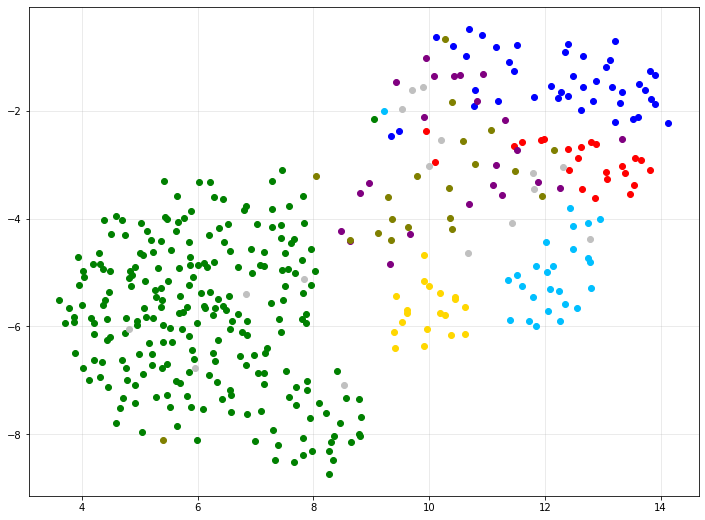

In [64]:
# main part -- calculation embedding
# the result is cashed, so you can compute the embedding 
# once and then set calc_res as false use it and e.g. tune the plot

calc_res = False
show_res = True
is_umap = True

if calc_res:
    proximity_matrix = deputy_vote_result.to_numpy()
    proximity_matrix = proximity_matrix / np.max(proximity_matrix)

    if not is_umap:
        mds = manifold.MDS(
            n_components=2,
            max_iter=20000,
            n_init=5,
            eps=1e-9,
            dissimilarity="precomputed",
            random_state=5,
            n_jobs=2
        )

        res = mds.fit((1 - proximity_matrix))
        pos = res.embedding_
        print("Stress:", res.stress_)
    else:
        embedding = umap.UMAP(
            n_neighbors=404,
            min_dist=0.8,
            metric='precomputed'
        ).fit_transform((1 - proximity_matrix))
        pos = embedding

    pos_df = pd.DataFrame(pos)
    pos_df.to_csv("position_df.csv", index_label="row_id")

if show_res:
    pos_df = pd.read_csv("position_df.csv")
    pos = pos_df.to_numpy()

    fig, ax = plt.subplots(figsize=[12, 9])
    ax.grid(True, alpha=0.3)

    pos_df['dep_id'] = deputy_vote_result.index
    pos_df = pos_df.set_index('dep_id')

    pos_df = pd.concat([pos_df, deputy_profile], axis=1, join='inner')
    sn_df = pos_df[pos_df['party'] == 'СН']

    pos_df.columns = ['id', '0', '1', 'name', 'party']

    # fraction indexes and colors in the same order

    fraction_indexes = [
        sn_index, opzg_index, yula_index, zm_index, es_index, golos_index, poza_index, dovira_index
    ]
    fraction_colors = [
        "green", "#0000FF", "#FF0000", "#800080", "#00BFFF", '#FFD700', "#C0C0C0", "#808000"
    ]

    all_labels = []
    for fraction in fraction_indexes:
        curr_labels = []
        for row_id in fraction:
            label = pos_df[pos_df['id'] == row_id].T
            label.columns = ['Row {0}'.format(pos_df.index[pos_df['id'] == row_id].tolist())]
            curr_labels.append(str(label.to_html()))

        all_labels.append(curr_labels)


    points = []

    for fraction, color in zip(fraction_indexes, fraction_colors):
        points.append(
            ax.plot(
                [x[1] for i, x in enumerate(pos) if i in fraction],
                [x[2] for i, x in enumerate(pos) if i in fraction],
                'o', color=color
            )
        )

    for i, point in enumerate(points):
        tooltip = plugins.PointHTMLTooltip(
            point[0],
            all_labels[i],
            voffset=10,
            hoffset=10,
            css=css
        )
        plugins.connect(fig, tooltip)

    mpld3.show(fig)

Какие выводы можно сделать:

* При любом типе визуализации очень интересна близость лидеров двух максимально противоположных партий -- Петра Порошенка и Вадима Рабиновича. Вообще в целом Петр Алексеевич весьма "далек" от своей партии и находится в компании скандальных Дубинского, Столара, Деркача, Рабиновича. Это стоит перепроверить еще раз, но по всем всем данным таки сходится
* Неоднородные "За Майбутне", примерно половина которой находятся в облаке ОПЗЖ, а вторая -- где-то между Батькивщиной, внефракционными депутатами и Слугой Народа
* Отличия между Голосом и ЕС, в частности Голос видимо более настроен сотрудничать с монобольшинством и чаще чем ЕС поддерживает СН
* Общий уровень внутрипартийного разнообразия -- Голос и ЕС как правило голосуют примерно одним фронтом, когда Батькивщина и ОПЗЖ допускают гораздо больший уровень внутрипартийного разнообразия и "плюрализма мнений". Самый большой уровень разнообразия у бренда Довіра, от полной поддержки СН, до полной поддержки ОПЗЖ
* Часть депутатов фракций Довіра и За Майбутне -- Гузь, Сухов, Шаповалов -- образуют группу, которая голосует весьма комплиментарно к СН и очень близко к Голосу